- 본 과정에서는 "Robust regression"을 다른 regression과 비교하여 볼 것입니다.

regression은 임의에 x 값이 변화됩에 따라 y값의 변화량이 선형적($y=ax^3+bx^2+cx+\epsilon\ \ or\ \ y=ax^2+bx+\epsilon\ \ or\ \ y=ax+\epsilon.\ \ $ etc)인지를 확률(p-value)로 정의한다. 따라서, 오차가 존재하고 더불어, 이상치에 따라 예측이 외곡될 수도 있다.

Robust regression은 이상치 탐색과 함께 회귀가 가능하다.
회귀의 기본적인 원리는 각 변수 확률적 분포에 대한 비교라고 볼 수도 있습니다. 이런 이유로 이상치(outlier)는 '평균', '편차'와 같은 변수에 대해 'summary statistics'를 왜곡할 수 있고, 분포의 기준이 되는 '중심값'을 외곡시키기 때문에 해당 변수의 분포의 변화를 초래하여  점에서 고질적인 문제가 됩니다. 

해당 문제를 해결하기 위한 방법으로 이상치 예상을 구체적으로 해결하는 수정된 선형회귀(Robust regression)을 사용합니다. 

In [37]:
# basic
import os
import numpy as np
import pandas as pd
from random import random, seed, randint

# visualization
import matplotlib.pyplot as plt 

# modeling
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, TheilSenRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score

In [2]:
def data_generator():
    X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, n_informative=1, noise=3, bias=50, random_state=1)
    # 데이터에 임의의 이상치를 추가합니다.
    seed(1)
    for i in range(10):
        # range(2, 5) {2 <= x < 5} 범위에 대한 임의의 수를 생성합니다.     
        factor = randint(2, 4)
        # 의의로 생성한 난수에 X의 표준편차를 곱한 수를 i번째 독립변수에 더하거나 빼줍니다.     
        if random() > 0.5:
            X[i] += factor * X.std()
        else:
            X[i] -= factor * X.std()    
    return X, y

X, y = data_generator()


	 - Data shape : (100, 2)



<Figure size 360x360 with 0 Axes>

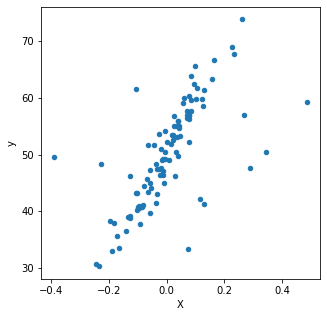

In [33]:
df_main = pd.DataFrame( columns=['X', 'y'] )
df_main.loc[:, 'X'] = list(map(lambda x: x[0], list(X)))
df_main.loc[:, 'y'] = y

print(f'\n\t - Data shape : {df_main.shape}\n')
df_main.plot.scatter(x='X', y='y', figsize=(5, 5))
plt.show()

위 그래프를 통해 확인할 수 있는 것은 선형적인 부분과 선형적 특성을 완전히 벗어나는 부분이 함게 있는 것입니다.

위 데이터를 가지고 '선형회귀'를 수행해보겠습니다.

In [44]:
def eval_model(X=X, y=y, model=LinearRegression()):
    '''
    cv: cross validation
    'neg_mean_absolute_error': MAE(Mean Absolute Error)
    '''
    
    cv    = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return np.absolute(score)

def vis_BF(i=0, X=X, y=y, model=LinearRegression()):
    x_ax = np.arange(X.min(), X.max(), step=0.01) 
    model.fit(X, y); y_ax = model.predict(x_ax.reshape((len(x_ax), 1)))
    
    axes[i].scatter(X, y)
    axes[i].plot(x_ax, y_ax, color='r', linestyle='dashed')
    axes[i].set_title(type(model).__name__)

                   Mean MAE       std
LinearRegression   5.260343  5.260343
HuberRegressor     4.434728  4.434728
TheilSenRegressor  4.371390  4.371390




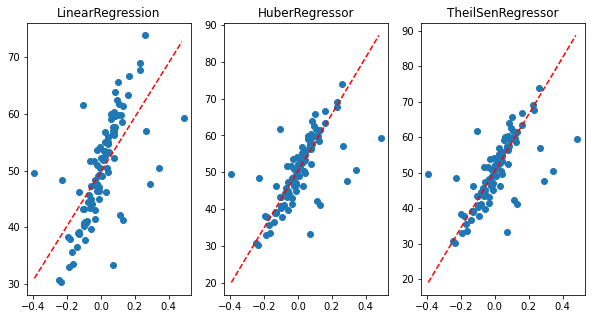

In [58]:
models = [LinearRegression(), HuberRegressor(), TheilSenRegressor()]
valL   = []; valdf = pd.DataFrame( columns=['Mean MAE', 'std'] )

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    vis_BF(i=i, model=models[i])
    sy = eval_model(model=models[i])
    valL.append((np.mean(sy), np.mean(sy)))

valdf.iloc[:, 0], valdf.iloc[:, 1] = zip(*valL)
valdf.index = [type(models[i]).__name__ for i in range(3)]
print(valdf); print('\n')
plt.show()